<a href="https://colab.research.google.com/github/HackerJacky/TimeSeriesColab/blob/main/ts_ch1_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import scipy.stats as stats

# 從本地資料，匯入csv檔案

In [2]:
from google.colab import files
uploaded = files.upload()

In [ ]:
#data = pd.read_csv('spx_index.csv')
#data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426 entries, 0 to 1425
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   secid           1426 non-null   int64  
 1   date            1426 non-null   object 
 2   cusip           1426 non-null   int64  
 3   ticker          1426 non-null   object 
 4   sic             1426 non-null   int64  
 5   index_flag      1426 non-null   int64  
 6   exchange_d      1426 non-null   int64  
 7   class           0 non-null      float64
 8   issue_type      1426 non-null   object 
 9   industry_group  0 non-null      float64
 10  low             1426 non-null   float64
 11  high            1426 non-null   float64
 12  open            1426 non-null   float64
 13  close           1426 non-null   float64
 14  volume          1426 non-null   int64  
 15  return          1426 non-null   float64
 16  cfadj           1426 non-null   int64  
 17  shrout          1426 non-null   i

In [ ]:
#data.index = pd.to_datetime(data.date)

In [ ]:
#data = data[['close','return']]
#data.head()

,close,return
date,,
2018-01-02,2695.81,0.008303
2018-01-03,2713.06,0.006399
2018-01-04,2723.99,0.004029
2018-01-05,2743.15,0.007034
2018-01-08,2747.71,0.001662


<Axes: xlabel='date'>

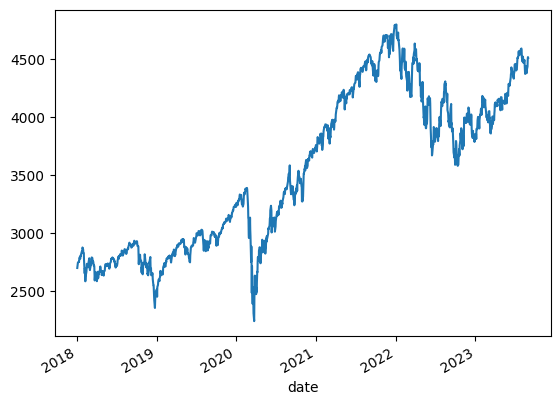

In [ ]:
#data.close.plot()

# 透過ccxt套件，下載加密貨幣交易所交易資料


In [3]:
!pip install --upgrade ccxt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.6/288.6 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.13
    Uninstalling aiohttp-3.11.13:
      Successfully uninstalled aiohttp-3.11.13


In [ ]:
import ccxt
print(ccxt.__version__)


4.4.67


# 使用cctx套件下載加密貨幣資料
- binance無法在台灣地區下載
- coinbase可以
- 日頻率: `1d`


In [ ]:
import ccxt
import pandas as pd
import time

# 建立 Coinbase 交易所物件（新版 ccxt 使用 coinbase 名稱，對應 Coinbase Pro）
exchange = ccxt.coinbase({
    'enableRateLimit': True,  # 啟用速率限制管理
})

symbol = 'BTC/USD'
timeframe = '5m'  # 日線資料

# 設定起始日期：2017-01-01（ISO 8601 格式）
since = exchange.parse8601('2017-01-01T00:00:00Z')

# 用以存放所有下載的 OHLCV 資料
all_ohlcv = []

while True:
    # 每次請求最多取 500 筆資料
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit=500)
    if not ohlcv:
        break
    all_ohlcv.extend(ohlcv)

    # 取得本批資料最後一筆的時間戳（毫秒級）
    last_timestamp = ohlcv[-1][0]
    # 若最後一筆資料的時間戳已接近或超過目前時間，則停止迴圈
    if last_timestamp >= exchange.milliseconds():
        break
    # 更新 since 參數，設定為上一批資料最後一筆的時間戳 + 1 毫秒，以避免資料重複
    since = last_timestamp + 1
    # 遵循速率限制，暫停一段時間
    time.sleep(exchange.rateLimit / 1000)

# 整理資料成 pandas DataFrame
df = pd.DataFrame(all_ohlcv, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
df.set_index('Timestamp', inplace=True)

# 顯示前五筆與最後五筆資料
print("前五筆資料：")
print(df.head())
print("\n最後五筆資料：")
print(df.tail())


前五筆資料：
                       Open    High     Low   Close     Volume
Timestamp                                                     
2017-01-01 00:00:00  973.37  973.40  973.35  973.39   7.620848
2017-01-01 00:05:00  973.35  973.39  970.95  972.62  30.471846
2017-01-01 00:10:00  971.94  971.94  970.42  970.42  20.020347
2017-01-01 00:15:00  970.42  971.18  969.90  969.90  10.810664
2017-01-01 00:20:00  970.09  970.77  969.94  970.77  14.584984

最後五筆資料：
                         Open      High       Low     Close     Volume
Timestamp                                                             
2025-02-19 17:00:00  96291.30  96432.24  96263.56  96432.24  52.583081
2025-02-19 17:05:00  96429.23  96450.00  96312.01  96336.11  30.656844
2025-02-19 17:10:00  96336.11  96344.47  96190.63  96218.26  25.072654
2025-02-19 17:15:00  96218.01  96377.00  96218.01  96377.00  25.294159
2025-02-19 17:20:00  96377.00  96411.20  96301.45  96310.62   9.392176


In [ ]:
# 匯出資料
df.to_csv('btcusd_coinbase_5m.csv')

# 建立報酬率
- 下載資料
- 理解資料欄位
- 整理資料
- 建立報酬率變數

In [33]:
# 下載資料
# For S&P 500 index (^gspc)
data = yf.download('^gspc')
data.head().round(3)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1927-12-30,17.66,17.66,17.66,17.66,0
1928-01-03,17.76,17.76,17.76,17.76,0
1928-01-04,17.72,17.72,17.72,17.72,0
1928-01-05,17.55,17.55,17.55,17.55,0
1928-01-06,17.66,17.66,17.66,17.66,0


In [38]:
# 整理資料
#data = data['2020':]
#data = data[['Close']]
data.columns = ['price_spx']
data.head().round(3)
#data.info()

,price_spx
Date,
2020-01-02,3257.85
2020-01-03,3234.85
2020-01-06,3246.28
2020-01-07,3237.18
2020-01-08,3253.05


In [88]:
# 建立報酬率變數
# percentage return
data['ret_spx_1'] = data.price_spx.pct_change()
#data.head().round(3)
#del data['ret_spx1']
data['ret_spx'] = np.log(data.price_spx).diff()
#data['aaa']=(data.price_spx-data.price_spx.shift())/data.price_spx.shift()
#data['aaa'].head()

#del data['aaa']  #也可以使用drop函數
#data.head().round(3)
#data['diff_ret'] = data.ret_spx_1 - data.ret_spx_2
#data.diff_ret.plot()

In [54]:
data.head()

,price_spx,ret_spx,ret_spx_1
Date,,,
2020-01-02,3257.850098,NaN,NaN
2020-01-03,3234.850098,-0.007085,-0.007060
2020-01-06,3246.280029,0.003527,0.003533
2020-01-07,3237.179932,-0.002807,-0.002803
2020-01-08,3253.050049,0.004890,0.004902


<ipython-input-87-640d5014a685>:18: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
<ipython-input-87-640d5014a685>:18: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


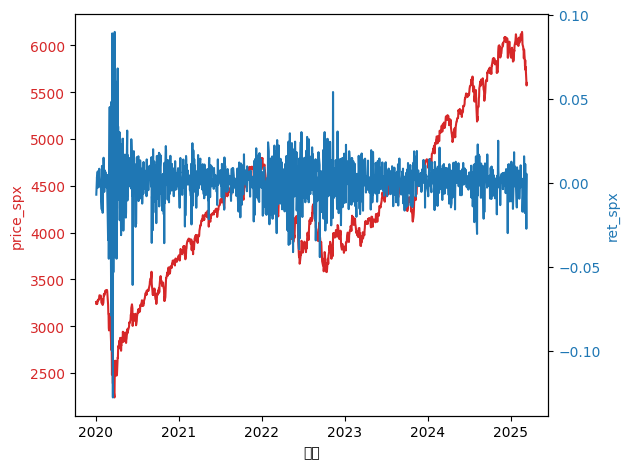

In [87]:
# plot
fig, ax1 = plt.subplots()

# 設定第一個 y 軸，用於 price_spx
color = 'tab:red'
ax1.set_xlabel('時間')
ax1.set_ylabel('price_spx', color=color)
ax1.plot(data.index, data['price_spx'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 設定第二個 y 軸，用於 ret_spx
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('ret_spx', color=color)  # we already handled the x-label with ax1
ax2.plot(data.index, data['ret_spx'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Exercises
- 根據上述例子，觀察百分比報酬率與log報酬之間的差異，並檢定是否顯著異於零
- 下載台股加權指數並建立其報酬率變數
- 下載比特幣價格並建立報酬率變數
- 觀察這些資產的**價格走勢**與其報酬率的**相關性**

In [108]:
#1
#data['dif_ret'] = data.ret_spx_1 - data.ret_spx
data[['ret_spx_1', 'ret_spx']] = data[['ret_spx_1', 'ret_spx']].fillna(0)

u_stat, p_value = stats.mannwhitneyu(data.ret_spx_1,data.ret_spx, alternative='two-sided')
print(f"Mann-Whitney U 統計值: {u_stat}, p 值: {p_value}")

# Mann-Whitney U 統計值: 853113.5, p 值: 0.9337368208388747
#可以判定如果兩個資料集的p-value<0.05就表示兩個資料集是現住差異
#這題的p-value是0.9337所以兩者沒有現住的差異

#data.dif_ret.plot()


Mann-Whitney U 統計值: 853113.5, p 值: 0.9337368208388747


In [133]:
#2

data_tw =yf.download('^TWII')
data_tw = data_tw.loc['2020':]
data_tw = data_tw[['Close']]
data_tw.columns = ['price_twii']
data_tw.fillna(0)

data_tw['ret_twii'] = np.log(data_tw.price_twii).diff()
data_tw['ret_twii_1']=data_tw.price_twii.pct_change()


#data_tw.plot()




[*********************100%***********************]  1 of 1 completed


In [142]:
#3
data_bit=yf.download('BTC-USD')
data_bit=data_bit.loc['2020':]
data_bit=data_bit[['Close']]
data_bit.columns =['price_BTC']

data_bit['ret_BTC'] = np.log(data_bit.price_BTC).diff()
data_bit['ret_BTC_2']=data_bit.price_BTC.pct_change()
data_bit.fillna(0)

data_bit.head()
#data_bit.plot()


[*********************100%***********************]  1 of 1 completed


,price_BTC,ret_BTC,ret_BTC_2
Date,,,
2020-01-01,7200.174316,NaN,NaN
2020-01-02,6985.470215,-0.030273,-0.029819
2020-01-03,7344.884277,0.050172,0.051452
2020-01-04,7410.656738,0.008915,0.008955
2020-01-05,7411.317383,0.000089,0.000089


ValueError: x and y must have same first dimension, but have shapes (1258, 3) and (1899,)

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtool

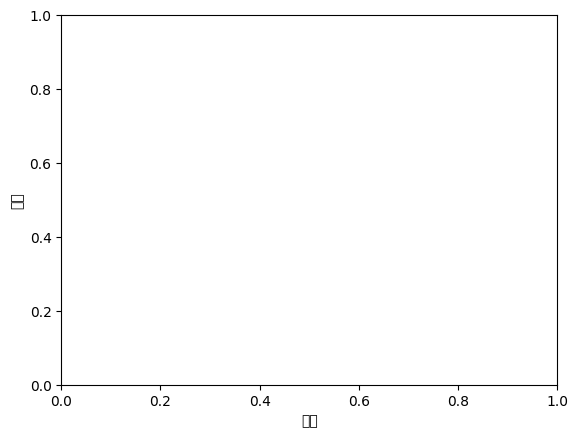

In [136]:
#4
plt.xlabel('時間')
plt.ylabel('價格')

plt.plot(data_tw,data_bit)

# 落後運算元
- 將當期資料移到前一期資料，我們可利用$L$進行運算
- 該運算元$L$，我們稱之為落後運算元
- Python中我們也有對應函數

-0.5489833674205759

In [56]:
data.head()

,price_spx,ret_spx,ret_spx_1
Date,,,
2020-01-02,3257.850098,NaN,NaN
2020-01-03,3234.850098,-0.007085,-0.007060
2020-01-06,3246.280029,0.003527,0.003533
2020-01-07,3237.179932,-0.002807,-0.002803
2020-01-08,3253.050049,0.004890,0.004902


In [ ]:
# 落後運算元函數 .shift()
data['ret_spx_1_L2'] = data['ret_spx_1'].shift(2)
data.head()

,price_spx,ret_spx_1,ret_spx_2,diff_ret,ret_spx_1_L1,ret_spx_1_L2
Date,,,,,,
2020-01-02,3257.850098,NaN,NaN,NaN,NaN,NaN
2020-01-03,3234.850098,-0.007060,-0.007085,0.000025,NaN,NaN
2020-01-06,3246.280029,0.003533,0.003527,0.000006,-0.007060,NaN
2020-01-07,3237.179932,-0.002803,-0.002807,0.000004,0.003533,-0.007060
2020-01-08,3253.050049,0.004902,0.004890,0.000012,-0.002803,0.003533


# 模擬白噪音
- 白噪音的生成可利用標準常態分佈的亂數生成函數
- 標準常態分佈亂數生成 `np.random.randn()`
- 白噪音分佈可記為，
$$
WN(0,\sigma^2)
$$

In [91]:
np.random.randn

<function RandomState.randn>

In [92]:
# construct a white noise
# white noise
# mean=0, variance=sigma^2
mu = 0
sigma = 2
# set random seed
#np.random.seed(1234)
wn = mu + sigma*np.random.randn(1000)

In [93]:
wn[:5]

array([-2.59185794, -2.20129434, -0.53377943, -0.18139211, -1.30168604])

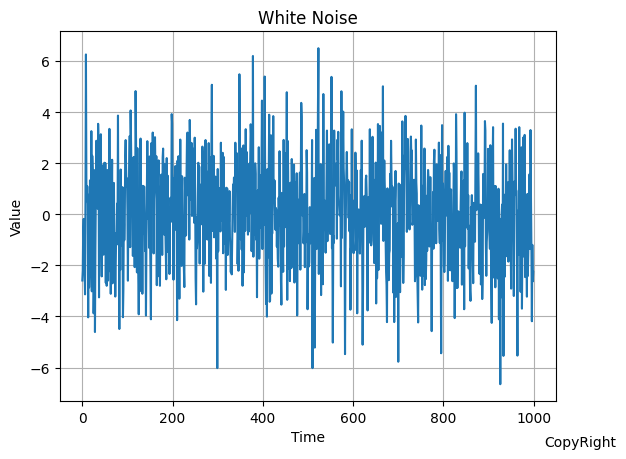

In [94]:
plt.plot(wn)
plt.title('White Noise')
plt.xlabel('Time')
plt.ylabel('Value')
plt.figtext(0.995, 0.01, 'CopyRight', ha='right', va='bottom')
plt.grid('True')

# 自我相關係數
- 下載匯率和股價資料
- 計算一階自我相關係數 `A.corr(A.shift())`
- 比較其自我相關係數的大小
  - 分別下載資料
  - 合併資料 `pd.merge()`

In [ ]:
# download exchange rate USD/EUR or TWD=X
test = yf.download('TWD=X')
test = test['2020':]
test = test[['Adj Close']]
test.columns = ['price_twdusd']
test.info()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1125 entries, 2020-01-01 to 2024-04-23
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price_twdusd  1125 non-null   float64
dtypes: float64(1)
memory usage: 17.6 KB


In [ ]:
test.head()

,price_twdusd
Date,
2020-01-01,29.898001
2020-01-02,29.844000
2020-01-03,29.900000
2020-01-06,30.035000
2020-01-07,30.047001


In [ ]:
# merge by data.index and test.index
data = pd.merge(data,test, left_index=True, right_index=True)

In [ ]:
data['ret_twdusd'] = np.log(data.price_twdusd).diff()


In [ ]:
data.ret_spx.corr(data.ret_twdusd)

-0.004285846010111665

根據上述的測試，我們發現，
- 匯率的自我相關係數高達0.997 (可能是非定態)
- 股價指數也有上述現象，故分析這兩種類型資料應先做一階差分，或者是建立報酬率變數
- S&P500指數跟新台幣兌美元的匯率是無關的

<Axes: xlabel='Date'>

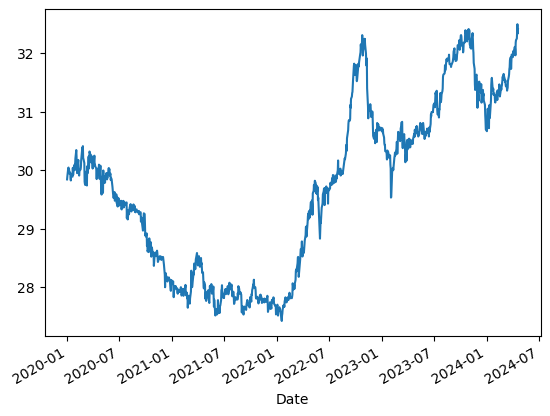

In [ ]:
data.price_twdusd.plot()

In [ ]:
# calculate the first-order autocorrelation of price_spx
data.price_spx.corr(data.price_spx.shift())


0.9963371235091717

# 建立固定趨勢模型
- 建立時間趨勢變數
- 建立時間趨勢模型

In [ ]:
# construct the time trend variable
data['t_trend'] = range(len(data.price_twdusd))
data.head()

,price_spx,ret_spx,price_twdusd,ret_twdusd,t_trend
Date,,,,,
2020-01-02,3257.850098,NaN,29.844000,NaN,0
2020-01-03,3234.850098,-0.007085,29.900000,0.001875,1
2020-01-06,3246.280029,0.003527,30.035000,0.004505,2
2020-01-07,3237.179932,-0.002807,30.047001,0.000399,3
2020-01-08,3253.050049,0.004890,29.985001,-0.002066,4


In [ ]:
# time-trend regression
x = sm.add_constant(data['t_trend'])
y = data.price_spx
result = sm.OLS(y,x,missing='drop').fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              price_spx   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     1364.
Date:                Tue, 23 Apr 2024   Prob (F-statistic):          8.83e-194
Time:                        03:51:09   Log-Likelihood:                -7975.5
No. Observations:                1083   AIC:                         1.595e+04
Df Residuals:                    1081   BIC:                         1.596e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3299.3776     23.218    142.103      0.0

<Axes: xlabel='Date'>

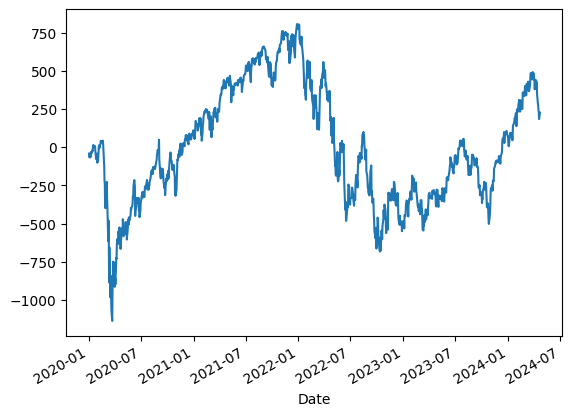

In [ ]:
result.resid.plot()

# 建立季節性趨勢模型
- 建立季節性趨勢變數
- 建立季節性趨勢模型

In [ ]:
# 建立季節性dummy
data['q_dum_1'] = 0
data['q_dum_2'] = 0
data['q_dum_3'] = 0

data['q_dum_1'][data.index.quarter == 1] = 1
data['q_dum_2'][data.index.quarter == 2] = 1
data['q_dum_3'][data.index.quarter == 3] = 1

<ipython-input-33-4e1685fc3da8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['q_dum_1'][data.index.quarter == 1] = 1
<ipython-input-33-4e1685fc3da8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['q_dum_2'][data.index.quarter == 2] = 1
<ipython-input-33-4e1685fc3da8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['q_dum_3'][data.index.quarter == 3] = 1


In [ ]:
# construct the season dummy into our model
x = sm.add_constant(data[['q_dum_1','q_dum_2','q_dum_3']])
y = data.price_spx
result = sm.OLS(y,x,missing='drop').fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              price_spx   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     5.160
Date:                Tue, 23 Apr 2024   Prob (F-statistic):            0.00152
Time:                        03:54:45   Log-Likelihood:                -8409.7
No. Observations:                1083   AIC:                         1.683e+04
Df Residuals:                    1079   BIC:                         1.685e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4118.0573     35.852    114.862      0.0

# 檢驗模型的配適性


In [ ]:
# obtain the residual of the model
result.fittedvalues